In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from scipy.optimize import curve_fit

In [2]:
import sys
sys.path.append('../')  # go to parent dir
sys.path.append('/home/artem/git/sdafe-utils')

In [3]:
from sdafe.ch21.splines import plot_gam

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter, Formula, FloatVector, FactorVector

np_cv_rules = default_converter + numpy2ri.converter + pandas2ri.converter

In [5]:
mgcv = importr('mgcv')
rbase = importr('base')

### 21.7.1 Additive Model for Wages, Education and Experience

In [6]:
data = pd.read_csv('../data/CPS1988.csv')
data.head()

,wage,education,experience,ethnicity,smsa,region,parttime
0,354.94,7,45,cauc,yes,northeast,no
1,123.46,12,1,cauc,yes,northeast,yes
2,370.37,9,9,cauc,yes,northeast,no
3,754.94,11,46,cauc,yes,northeast,no
4,593.54,12,36,cauc,yes,northeast,no


In [7]:
fmla = Formula('log(wage) ~ s(education) + s(experience) + ethnicity')
fmla.environment['wage'] = FloatVector(data['wage'])
fmla.environment['education'] = FloatVector(data['education'])
fmla.environment['experience'] = FloatVector(data['experience'])
fmla.environment['ethnicity'] = FloatVector((data['ethnicity'] == 'afam') * 1)

#### Problem 1

The estimate of $\beta_0$ is 6.19 and the estimate of $\beta_1$ is -0.24:

In [8]:
fit = mgcv.gam(fmla)
rbase.print(rbase.summary(fit));


Family: gaussian 
Link function: identity 

Formula:
log(wage) ~ s(education) + s(experience) + ethnicity

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.189742   0.003558    1740   <2e-16 ***
ethnicity   -0.241280   0.012697     -19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                edf Ref.df      F p-value    
s(education)  7.653  8.359  613.1  <2e-16 ***
s(experience) 8.906  8.995 1208.5  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.36   Deviance explained = 36.1%
GCV = 0.32802  Scale est. = 0.3278    n = 28155


#### Problem 2

The curve for `education` is everywhere increasing, however the rate of increase is higher in the region above roughly 10 years.

The curve for `experience` is increasing rapidly in the region 0 to 10 years, levels off between 20 and 40 years and then drops between 40 and 50 years. The upward turn beyond 55 years is likely a random artifact due to insufficient data in that region.

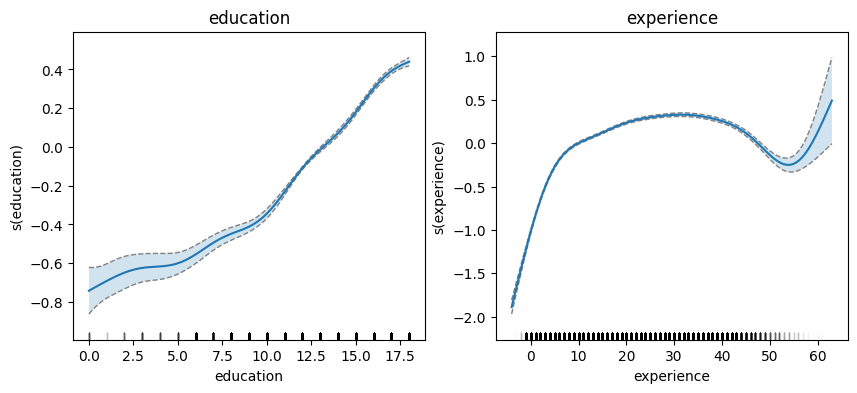

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_gam(fit, data, fig.axes);
sns.rugplot(data['education'], ax=axs[0], color='black', alpha=0.01);
sns.rugplot(data['experience'], ax=axs[1], color='black', alpha=0.01);

#### Using the functionality from `statsmodels`

In [10]:
from statsmodels.gam.api import GLMGam, BSplines

In [11]:
x_spline = data[['education', 'experience']]
bs = BSplines(x_spline, df=[10, 10], degree=[3, 3])

In [12]:
gam_bs = GLMGam.from_formula('np.log(wage) ~ ethnicity', data=data, smoother=bs)

In [13]:
res_bs = gam_bs.fit()
res_bs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           np.log(wage)   No. Observations:                28155
Model:                         GLMGam   Df Residuals:                    28135
Model Family:                Gaussian   Df Model:                        19.00
Link Function:               Identity   Scale:                         0.32785
Method:                         PIRLS   Log-Likelihood:                -24241.
Date:                Sun, 14 May 2023   Deviance:                       9223.9
Time:                        23:23:03   Pearson chi2:                 9.22e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4310
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.5159      0.176     20.017      0.000       3.172       3.860
ethnicity[T.cauc]     0.2403      0.013     18.919      0.000       0.215       0.265
education_s0          0.2346      0.130      1.800      0.072      -0.021       0.490
education_s1          0.0625      0.073      0.850      0.395      -0.081       0.206
education_s2          0.5941      0.069      8.646      0.000       0.459       0.729
education_s3          0.6646      0.061     10.859      0.000       0.545       0.785
education_s4          0.8051      0.072     11.250      0.000       0.665       0.945
education_s5          0.8004      0.065     12.260      0.000       0.672       0.928
education_s6          1.1506      0.066     17.408      0.000       1.021       1.280
education_s7          1.1011      0.075     14.641      0.000       0.954       1.249
education_s8          1.1788      0.061     19.409      0.000       1.060       1.298
experience_s0         0.2996      0.218      1.372      0.170      -0.128       0.728
experience_s1         1.4665      0.147      9.972      0.000       1.178       1.755
experience_s2         1.6160      0.173      9.350      0.000       1.277       1.955
experience_s3         1.8081      0.163     11.120      0.000       1.489       2.127
experience_s4         1.8978      0.168     11.323      0.000       1.569       2.226
experience_s5         2.0007      0.165     12.117      0.000       1.677       2.324
experience_s6         2.1385      0.172     12.435      0.000       1.801       2.476
experience_s7         1.3847      0.182      7.590      0.000       1.027       1.742
experience_s8         1.3245      0.236      5.619      0.000       0.862       1.786
=====================================================================================
"""

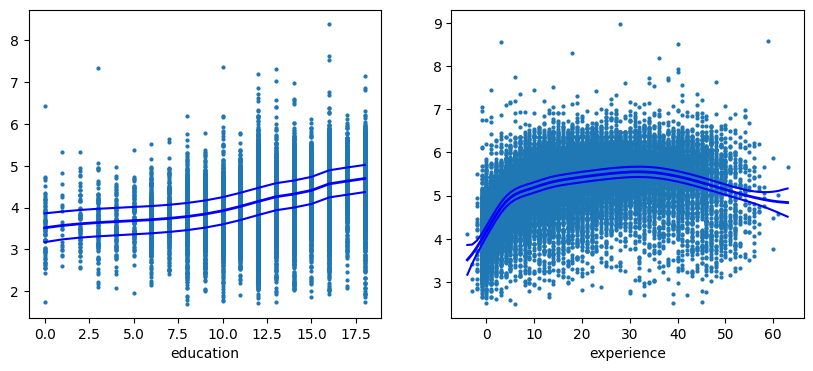

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
res_bs.plot_partial(0, cpr=True, ax=axs[0]);
res_bs.plot_partial(1, cpr=True, ax=axs[1]);

### 21.7.2 An Extended CKLS Model for the Short Rate

In [15]:
data = pd.read_csv('../data/Irates.csv', index_col=0)
data.head()

,r1,r2,r3,r5,r6,r11,r12,r36,r60,r120
Year,,,,,,,,,,
1946.916667,0.325,0.422,0.477,0.549,0.577,0.698,0.720,1.145,1.415,1.825
1947.000000,0.322,0.427,0.485,0.555,0.583,0.698,0.718,1.119,1.386,1.824
1947.083333,0.326,0.419,0.473,0.543,0.571,0.693,0.715,1.140,1.406,1.817
1947.166667,0.318,0.441,0.508,0.583,0.610,0.718,0.737,1.105,1.364,1.804
1947.250000,0.302,0.445,0.521,0.606,0.637,0.759,0.780,1.172,1.416,1.815


In [16]:
r1 = data['r1']
r1_lag = r1.shift().dropna()
r1_diff = r1.diff().dropna()
n = r1_lag.shape[0]

In [17]:
knots = np.linspace(1950, 1985, 10)
t = np.linspace(1946, 1991 + 2 / 12, n)

In [18]:
X1 = t.reshape(-1, 1) - knots.reshape(1, -1)
X2 = X1 * (X1 > 0)
X3 = np.hstack([np.ones(n).reshape(-1, 1), t.reshape(-1, 1) - 1946, X2])

In [19]:
m2 = X3.shape[1]
m = m2 - 1

#### Problem 3

The R code uses 10 knots.

The `outer` function produces a matrix of values $x - t_k$, where $x$ are grid points and $t_k$ are knots.

The statement `X2 = X1 * (X1>0)` produces the values of the plus function $(x - t_k)_+$.

The `X3` variable contains values of the basis functions.

In [20]:
def curve(x, *theta):
    return (X3[:, 0:2] @ theta[0:2]) * (X3 @ theta[2:] - x)

In [21]:
fit = curve_fit(curve, r1_lag, r1_diff, p0 = np.concatenate([[0.01, 0.0, 10], np.repeat(0, m)]))

In [22]:
a = fit[0][:2]
theta = fit[0][2:]

In [23]:
resid = r1_diff - (X3[:, 0:2] @ a) * (X3 @ theta - r1_lag)
resid_sq = resid ** 2

In [24]:
res_fit = curve_fit(lambda x, *param: param[0] * x ** param[1], r1_lag, resid_sq, p0 = [0.2, 0.5])[0]

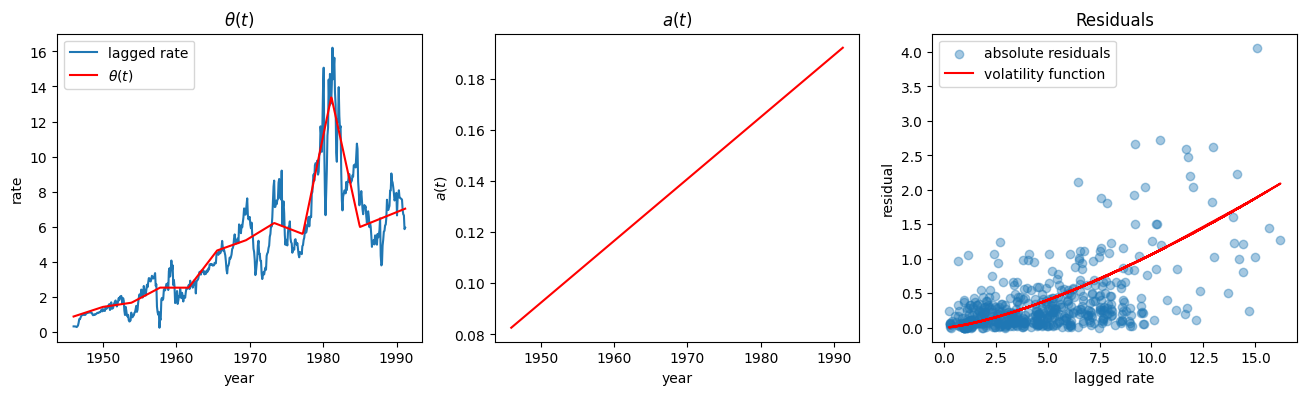

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].plot(t, r1_lag, label='lagged rate');
axs[0].plot(t, X3 @ theta, color='red', label='$\\theta(t)$');
axs[0].set_title('$\\theta(t)$');
axs[0].set_xlabel('year');
axs[0].set_ylabel('rate');
axs[0].legend();

axs[1].plot(t, X3[:, 0:2] @ a, color='red');
axs[1].set_title('$a(t)$');
axs[1].set_xlabel('year');
axs[1].set_ylabel('$a(t)$');

axs[2].scatter(r1_lag, np.abs(resid), alpha=0.4, label='absolute residuals');
axs[2].plot(r1_lag, np.sqrt(res_fit[0] * r1_lag ** res_fit[1]), color='red', label='volatility function');
axs[2].set_title('Residuals');
axs[2].set_xlabel('lagged rate');
axs[2].set_ylabel('residual');
axs[2].legend();

#### Problem 4

`X3[,0:2]` contains the constant and linear terms, hence `X3[,0:2] @ a` is a linear function of time.

By contrast, the full matrix `X3` also contains the plus-function terms, hence `X3 @ theta` is a spline.

#### Problem 5

$\theta(t)$ is the mean level to which the rate reverts in the shorter time frame. In the longer time frame, the mean level itself evolves, hence its time dependency.

#### Problem 6

The fitted slope of $a(t)$ is:

In [26]:
fit[0][1]

0.0024229553986188875

The standard error of the estimate is of the same magnitude, therefore we cannot reject the hypothesis that the slope is 0:

In [27]:
np.sqrt(np.diag(fit[1]))[1]

0.002706109113871766